## Introducing the DAG
In Qiskit, we represent circuits internally using a Directed Acyclic Graph (DAG). The advantage of this representation over a pure list of gates (i.e., netlist) is that the flow of information between operations are explicit, making it easier for passes to make transformation decisions without changing the semantics of the circuit.

Let's start by building a simple circuit, and examining its DAG

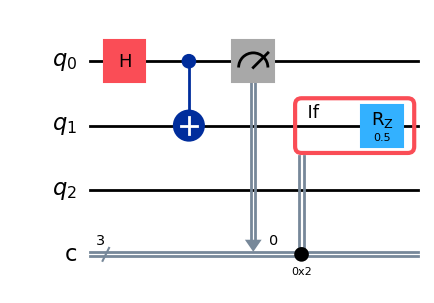

In [21]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import circuit_drawer
from qiskit.visualization.dag_visualization import dag_drawer

# Create circuit
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
circ = QuantumCircuit(q, c)
circ.h(q[0])
circ.cx(q[0], q[1])
circ.measure(q[0], c[0])

# Qiskit 2.0 uses if_test instead of c_if
with circ.if_test((c, 2)):
    circ.rz(0.5, q[1])

circuit_drawer(circ, output='mpl')

In the DAG, there are three kinds of graph nodes: qubit/clbit input nodes (green), operation nodes (blue), and output nodes (red). Each edge indicates data flow (or dependency) between two nodes.

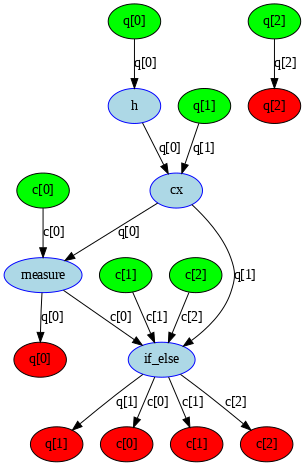

In [1]:
# Convert to DAG
dag = circuit_to_dag(circ)
dag_drawer(dag)

Therefore, writing a transpiler pass means using Qiskit's DAGCircuit API to analyze or transform the circuit. Let's see some examples of this.

## a. Get all op nodes in the DAG:

In [2]:
dag.op_nodes()


[DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(3, "q"), index=0>,), cargs=()),
 DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>), cargs=()),
 DAGOpNode(op=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qargs=(<Qubit register=(3, "q"), index=0>,), cargs=(<Clbit register=(3, "c"), index=0>,)),
 DAGOpNode(op=Instruction(name='if_else', num_qubits=1, num_clbits=3, params=[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7daa44b38b10>, None]), qargs=(<Qubit register=(3, "q"), index=1>,), cargs=(<Clbit register=(3, "c"), index=0>, <Clbit register=(3, "c"), index=1>, <Clbit register=(3, "c"), index=2>))]

Each node is an instance of the DAGOpNode class. Let's examine the information stored in the fourth op node

In [3]:
node = dag.op_nodes()[3]
print("node name:", node.name)
print("op:", node.op)
print("qargs:", node.qargs)
print("cargs:", node.cargs)
print("condition:", node.op.condition)


node name: if_else
op: Instruction(name='if_else', num_qubits=1, num_clbits=3, params=[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7daa44b38b10>, None])
qargs: (<Qubit register=(3, "q"), index=1>,)
cargs: (<Clbit register=(3, "c"), index=0>, <Clbit register=(3, "c"), index=1>, <Clbit register=(3, "c"), index=2>)
condition: (ClassicalRegister(3, 'c'), 2)


## b. Add an operation to the back:

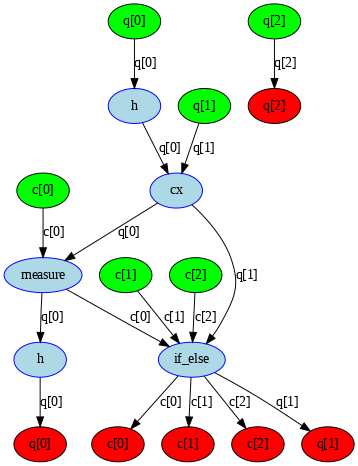

In [4]:
from qiskit.circuit.library import HGate
dag.apply_operation_back(HGate(), qargs=[q[0]])
dag_drawer(dag)


## c. Add an operation to the front:

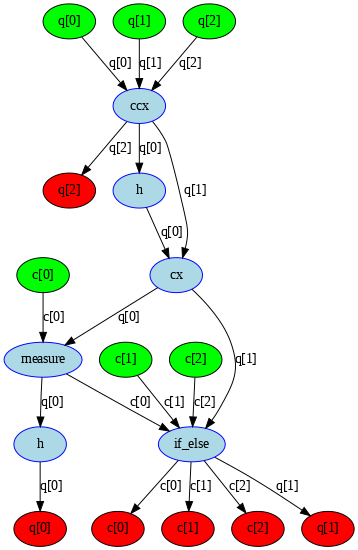

In [5]:
from qiskit.circuit.library import CCXGate
dag.apply_operation_front(CCXGate(), qargs=[q[0], q[1], q[2]])
dag_drawer(dag)


## d. Substitute a node with a subcircuit:

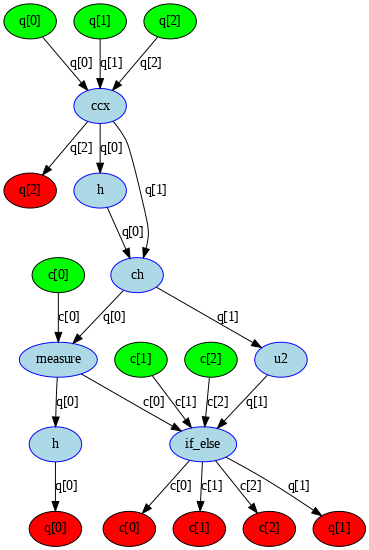

In [6]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit.library import CHGate, U2Gate, CXGate

# Build sub-DAG
mini_dag = DAGCircuit()
p = QuantumRegister(2, "p")
mini_dag.add_qreg(p)
mini_dag.apply_operation_back(CHGate(), qargs=[p[1], p[0]])
mini_dag.apply_operation_back(U2Gate(0.1, 0.2), qargs=[p[1]])

# Replace CX with mini_dag
cx_node = dag.op_nodes(op=CXGate).pop()
dag.substitute_node_with_dag(cx_node, mini_dag, wires=[p[0], p[1]])
dag_drawer(dag)


Finally, after all transformations are complete, we can convert back to a regular QuantumCircuit object. This is what the transpiler does! It takes a circuit, operates on it in DAG form, and outputs a transformed circuit.

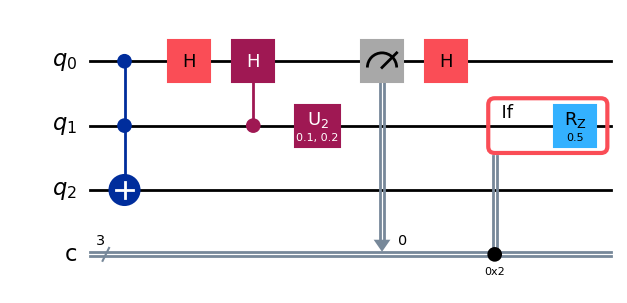

In [7]:
from qiskit.converters import dag_to_circuit
new_circ = dag_to_circuit(dag)
circuit_drawer(new_circ, output='mpl')


## Implementing a BasicMapper Pass

Now that we are familiar with the DAG, let's use it to write a transpiler pass. Here we will implement a basic pass for mapping an arbitrary circuit to a device with limited qubit connectivity. We call this the BasicMapper. This pass is included in Qiskit Terra as well.

The first thing to do when writing a transpiler pass is to decide whether the pass class derives from a TransformationPass or AnalysisPass. Transformation passes modify the circuit, while analysis passes only collect information about a circuit (to be used by other passes). Then, the run(dag) method is implemented, which does the main task. Finally, the pass is registered inside the qiskit.transpiler.passes module.

This pass functions as follows: it traverses the DAG layer-by-layer (each layer is a group of operations acting on independent qubits, so in theory all operations in a layer can be done independently). For each operation, if it does not already meet the coupling map constraints, the pass identifies a swap path and inserts swaps to bring the two qubits close to each other.

Follow the comments in the code for more details.

In [8]:
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.circuit.library import SwapGate
from qiskit.transpiler.exceptions import TranspilerError

class BasicSwap(TransformationPass):
    def __init__(self, coupling_map, initial_layout=None):
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        new_dag = DAGCircuit()
        for qreg in dag.qregs.values():
            new_dag.add_qreg(qreg)
        for creg in dag.cregs.values():
            new_dag.add_creg(creg)

        if self.initial_layout is None:
            self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())

        canonical_register = dag.qregs['q']
        current_layout = self.initial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer['graph']
            for gate in subdag.two_qubit_ops():
                q0, q1 = gate.qargs
                p0 = current_layout[q0]
                p1 = current_layout[q1]

                if self.coupling_map.distance(p0, p1) != 1:
                    path = self.coupling_map.shortest_undirected_path(p0, p1)
                    for i in range(len(path) - 2):
                        wire1, wire2 = path[i], path[i + 1]
                        qubit1 = current_layout[wire1]
                        qubit2 = current_layout[wire2]
                        new_dag.apply_operation_back(SwapGate(), qargs=[qubit1, qubit2])
                        current_layout.swap(wire1, wire2)

            new_dag.compose(subdag, qubits=current_layout.reorder_bits(new_dag.qubits))

        return new_dag


Let's test this pass on a small example circuit.

Now we construct a pass manager that contains our new pass. We pass the example circuit above to this pass manager, and obtain a new, transformed circuit.

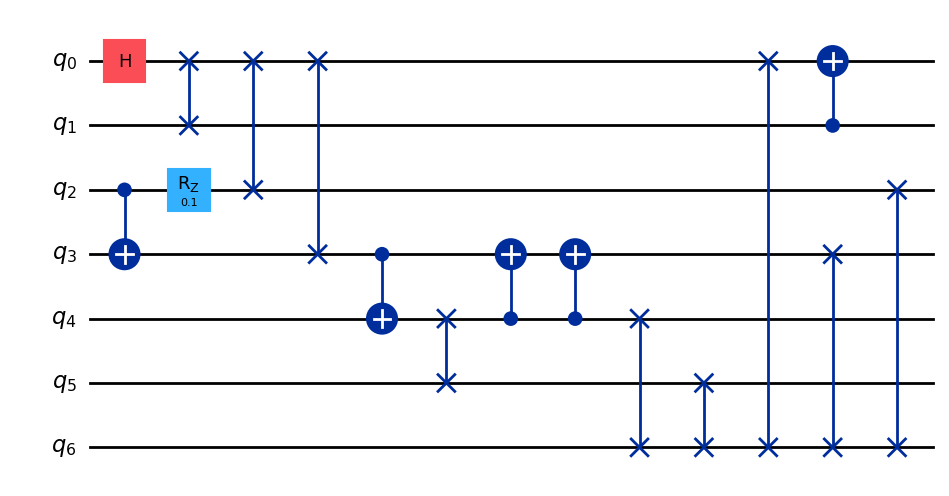

In [9]:
from qiskit.transpiler import CouplingMap, PassManager
from qiskit import QuantumRegister, QuantumCircuit

q = QuantumRegister(7, 'q')
in_circ = QuantumCircuit(q)
in_circ.h(q[0])
in_circ.cx(q[0], q[4])
in_circ.cx(q[2], q[3])
in_circ.cx(q[6], q[1])
in_circ.cx(q[5], q[0])
in_circ.rz(0.1, q[2])
in_circ.cx(q[5], q[0])

coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]
coupling_map = CouplingMap(couplinglist=coupling)

pm = PassManager()
pm.append(BasicSwap(coupling_map))

out_circ = pm.run(in_circ)

in_circ.draw(output='mpl')
out_circ.draw(output='mpl')


Note that this pass only inserts the swaps necessary to make every two-qubit interaction conform to the device coupling map. It does not, for example, care about the direction of interactions, or the native gate set supported by the device. This is a design philosophy of Qiskit's transpiler: every pass performs a small, well-defined action, and the aggressive circuit optimization is achieved by the pass manager through combining multiple passes.

 ## Exploring Circuit Layers with ``dag.serial_layers()``
 To analyze the structure of this circuit, we often want to examine the circuit layer by layer — that is, identify sets of operations that can be applied in parallel without violating quantum dependencies.

The following snippet demonstrates how to iterate through the layers of a DAG and inspect the operations in each:

In [25]:
for i, layer in enumerate(dag.serial_layers()):
    print(f"Layer {i}:")
    for node in layer['graph'].op_nodes():
        print(" ", node.name, node.qargs)


Layer 0:
  ccx (<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>)
Layer 1:
  h (<Qubit register=(3, "q"), index=0>,)
Layer 2:
  ch (<Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=0>)
Layer 3:
  u2 (<Qubit register=(3, "q"), index=1>,)
Layer 4:
  measure (<Qubit register=(3, "q"), index=0>,)
Layer 5:
  h (<Qubit register=(3, "q"), index=0>,)
Layer 6:
  if_else (<Qubit register=(3, "q"), index=1>,)


## Filtering Operations by Qubit
In quantum circuit optimization and analysis, it’s often useful to isolate and inspect all the operations that act on a specific qubit. The following code snippet demonstrates how to do this using Qiskit's ``DAGCircuit:``

In [28]:
target_qubit = dag.qubits[0]
nodes_on_qubit = [node for node in dag.op_nodes() if target_qubit in node.qargs]
print(f"Operations on {target_qubit}: {[node.name for node in nodes_on_qubit]}")


Operations on <Qubit register=(3, "q"), index=0>: ['h', 'measure', 'h', 'ccx', 'ch']


## Traversing a DAG in Topological Order
One of the most useful features of the DAGCircuit representation in Qiskit is its ability to expose the data dependencies of a quantum circuit explicitly. This makes it possible to iterate through operations in a valid execution order — respecting causal dependencies — using a topological sort.

Here’s how you can do that:

In [33]:
for node in dag.topological_op_nodes():
    print(node.name)


ccx
h
ch
u2
measure
h
if_else
